# Preprocesamiento y modelado de datos de viviendas

## Importación de librerías y carga de datos

In [1]:
!pip install -U scikit-learn==1.4.2 imbalanced-learn==0.12.2

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler

In [3]:
df_inicial = pd.read_csv(r"C:\Users\andre\OneDrive\Documentos\IMF\TFM\Modelado\viviendas_2011_2024.csv")
df_inicial.head()

,Ano,Distrito,Esperanza_vida,Renta_neta_persona,Renta_neta_hogar,Renta_bruta_persona,Renta_bruta_hogar,Edad_media,Mayores_65anos%,Menores_18anos%,...,Terraza,Planta,Exterior,Ascensor,Ano_construccion,Ano_reforma,Tipo_vivienda,Banos,Precio_predicho,Precio_ajustado
0,2011,CENTRO,83.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,0.0,False,False,NaN,NaN,apartamento,1,672.875811,657.471490
1,2011,CENTRO,83.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,5.0,True,True,NaN,NaN,apartamento,1,923.555035,894.792822
2,2011,CENTRO,83.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,3.0,True,True,1910.0,NaN,apartamento,2,1424.913483,1434.552312
3,2011,CENTRO,83.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,4.0,True,True,NaN,NaN,apartamento,1,2240.808388,2335.359589
4,2011,CENTRO,83.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,False,3.0,True,True,1940.0,NaN,apartamento,1,1583.237203,1571.481771


## Preprocesamiento

Revisar notebook [EDA_viviendas_2011_2024](./EDA_viviendas_2011_2024.ipynb) para visualizar el análisis que da lugar a las decisiones tomadas en el preprocesamiento.

### 1. Eliminar e imputar columnas

Eliminación de variables fuertemente correlacionadas, de variables con más del 90% de nulos e imputación de nulos de la columna "Planta".

In [4]:
df = df_inicial.copy()

# Elminación de Ano_construccion y Ano_reforma por exceso de nulos
df = df.drop(columns=['Ano_construccion', 'Ano_reforma'])

# Crear columna de indicador de nulos para Planta
df['Planta_is_missing'] = df['Planta'].isna().astype(int)

# Imputar valores nulos con la mediana para Planta (por distrito)
df['Planta'] = df.groupby('Distrito')['Planta'].transform(lambda x: x.fillna(x.median()))

# Variables muy correlacionadas y no usadas
var_corr = ['Tamano_vivienda_personas', 'Superficie_distrito_ha', 'Edad_media', 'Renta_neta_persona',
            'Renta_neta_hogar', 'Renta_bruta_persona', 'Renta_bruta_hogar', 'Precio_predicho']

df = df.drop(columns=var_corr)

print('Columnas restantes:', df.columns.to_list())

Columnas restantes: ['Ano', 'Distrito', 'Esperanza_vida', 'Mayores_65anos%', 'Menores_18anos%', 'Paro_registrado%', 'Apartamentos_turisticos', 'Densidad_poblacion', 'Zonas_verdes%', 'Habitaciones', 'Operacion', 'Tamano', 'Garaje', 'Trastero', 'Piscina', 'Terraza', 'Planta', 'Exterior', 'Ascensor', 'Tipo_vivienda', 'Banos', 'Precio_ajustado', 'Planta_is_missing']


### 2. Transformar variables categóricas

Se deben pasar las variables categóricas a numéricas para poder procesarlas correctamente con los modelos. Las tres variables categóricas son `Distrito`, `Operacion` y `Tipo_vivienda`. Como no son variables que tengan jerarquía, usaremos dummies para transformarlas.

In [5]:
df = pd.get_dummies(df, drop_first=True)

print(df.columns)

Index(['Ano', 'Esperanza_vida', 'Mayores_65anos%', 'Menores_18anos%',
       'Paro_registrado%', 'Apartamentos_turisticos', 'Densidad_poblacion',
       'Zonas_verdes%', 'Habitaciones', 'Tamano', 'Garaje', 'Trastero',
       'Piscina', 'Terraza', 'Planta', 'Exterior', 'Ascensor', 'Banos',
       'Precio_ajustado', 'Planta_is_missing', 'Distrito_BARAJAS',
       'Distrito_CARABANCHEL', 'Distrito_CENTRO', 'Distrito_CHAMARTIN',
       'Distrito_CHAMBERI', 'Distrito_CIUDADLINEAL',
       'Distrito_FUENCARRALELPARDO', 'Distrito_HORTALEZA', 'Distrito_LATINA',
       'Distrito_MONCLOAARAVACA', 'Distrito_MORATALAZ',
       'Distrito_PUENTEDEVALLECAS', 'Distrito_RETIRO', 'Distrito_SALAMANCA',
       'Distrito_SANBLASCANILLEJAS', 'Distrito_TETUAN', 'Distrito_USERA',
       'Distrito_VICALVARO', 'Distrito_VILLADEVALLECAS', 'Distrito_VILLAVERDE',
       'Operacion_venta', 'Tipo_vivienda_chalet', 'Tipo_vivienda_dúplex',
       'Tipo_vivienda_estudio', 'Tipo_vivienda_loft', 'Tipo_vivienda_mansión',


### 3. Dividir en entrenamiento, validación y test

**DECIDIR Y MODIFICAR - No se puede usar 2023 y 2024 para test o validación porque no tenemos variables input! Solo se pueden usar esos años para evaluar manualmente.**

Escogeremos años de 2015 a 2022 (ambos inclusive) para entrenamiento; año 2023 para validación; y año 2024 para test. Como se trata de una serie temporal, haremos la separación directamente en base a los años.

In [6]:
train_mask = (df['Ano'] >= 2015) & (df['Ano'] <= 2021)
val_mask = df['Ano'] == 2022
#test_mask = df['Ano'] == 2024

### 3. Preparar un pipeline de datos

Se utilizará un pipeline para facilitar el manejo de datos y evitar fugas. Para ello, elegimos un escalado robusto para procesar mejor los outliers; y un modelo para entrenar.

In [7]:
def definir_pipeline(modelo) -> Pipeline:
    """
    Función para aplicar escalado y decidir el modelo que se usará.
    
    Parameters
    ----------
    modelo : KNN, XGBoost, MLP...
        Se pueden incluir los parámetros manualmente dentro del modelo.
    
    Returns
    ----------
        pipeline
    """

    pipeline = Pipeline([
        ('scaler', RobustScaler()),
        ('modelo', modelo)
    ])

    return pipeline

**Faltaría a partir de aquí elegir modelos (recomendado por lo menos: baseline con un modelo linear o de distancias; un modelo de árboles; y un MLP). Se puede hacer optimización inteligente con Optuna. Validación para hacer pruebas, test cuando ya se haya optimizado lo posible.**

**Definición de variables, división temporal de datos y función de evaluación del modelo**

Variables predictoras (X) y la variable objetivo (y), separando los datos en entrenamiento (2015–2021) y validación (2022) para evitar fuga temporal. 
Además, se implementa una función de evaluación que entrena el modelo y calcula métricas de rendimiento (MAE, RMSE, MAPE y R²) en ambos conjuntos.

In [18]:
# ===== 1) Preparar X/y y splits temporales =====
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

TARGET_COL = "Precio_ajustado"   
DROP_COLS  = ["Ano", TARGET_COL] 
FEATURES   = [c for c in df.columns if c not in DROP_COLS]

X = df[FEATURES]
y = df[TARGET_COL]

train_mask = (df['Ano'] >= 2015) & (df['Ano'] <= 2021)
val_mask   = (df['Ano'] == 2022)

X_train, y_train = X[train_mask], y[train_mask]
X_val,   y_val   = X[val_mask],   y[val_mask]

def evaluar(model, X_tr, y_tr, X_va, y_va):
    model.fit(X_tr, y_tr)
    pred_tr = model.predict(X_tr)
    pred_va = model.predict(X_va)

    def mape(y_true, y_pred):
        eps = 1e-9
        return np.mean(np.abs((y_true - y_pred) / (np.abs(y_true) + eps))) * 100

    return {
        "MAE_train": mean_absolute_error(y_tr, pred_tr),
        "RMSE_train": mean_squared_error(y_tr, pred_tr, squared=False),
        "R2_train": r2_score(y_tr, pred_tr),
        "MAE_val": mean_absolute_error(y_va, pred_va),
        "RMSE_val": mean_squared_error(y_va, pred_va, squared=False),
        "MAPE_val_%": mape(y_va, pred_va),
        "R2_val": r2_score(y_va, pred_va),
    }


**Aquí tienes un título descriptivo y coherente con el estilo del anterior**

Definición y configuración de modelos representativos para la comparación de rendimiento predictivo
modelos representativos para comparar el rendimiento predictivo: un modelo lineal (Ridge) y uno basado en distancias (KNN) como baselines; dos modelos de árboles (Random Forest y HistGradientBoosting) que capturan relaciones no lineales; y una red neuronal (MLPRegressor) como aproximación más flexible. Todos se integran en un pipeline con escalado y parámetros base para evaluación inicial.

In [9]:
# ===== 2) Modelos: baseline lineal/distancias, árboles y MLP =====
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

modelos = {
    # Baselines
    "ridge": definir_pipeline(Ridge(alpha=1.0, random_state=42)),
    "knn":   definir_pipeline(KNeighborsRegressor(n_neighbors=7, weights="distance")),

    # Árboles
    "rf":    definir_pipeline(RandomForestRegressor(
                n_estimators=400, max_depth=None, n_jobs=-1, random_state=42)),
    "hgb":   definir_pipeline(HistGradientBoostingRegressor(
                max_depth=None, learning_rate=0.06, max_iter=500, random_state=42)),

    # MLP
    "mlp":   definir_pipeline(MLPRegressor(
                hidden_layer_sizes=(128, 64),
                activation="relu",
                learning_rate_init=1e-3,
                early_stopping=True,
                n_iter_no_change=20,
                random_state=42)),
}


**Entrenamiento, evaluación y selección del modelo con mejor rendimiento**

Se entrena cada modelo con los datos de entrenamiento y se evalúa su desempeño sobre el conjunto de validación (año 2022) utilizando métricas de error y precisión. Finalmente, se comparan los resultados y se selecciona el modelo con menor MAE, que en este caso corresponde al Random Forest (RF).

In [10]:
# ===== PASO 3 =====

import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.neural_network import MLPRegressor

# --- 3.1 Definir X/y y splits temporales ---
TARGET_COL = "Precio_ajustado"      # cambia si tu columna objetivo tiene otro nombre
DROP_COLS  = ["Ano", TARGET_COL]
FEATURES   = [c for c in df.columns if c not in DROP_COLS]

X = df[FEATURES]
y = df[TARGET_COL]

train_mask = (df['Ano'] >= 2015) & (df['Ano'] <= 2021)
val_mask   = (df['Ano'] == 2022)

X_train, y_train = X[train_mask], y[train_mask]
X_val,   y_val   = X[val_mask],   y[val_mask]

# --- 3.2 Función de evaluación (sin usar 'squared' para evitar el error) ---
def evaluar(model, X_tr, y_tr, X_va, y_va):
    model.fit(X_tr, y_tr)
    pred_tr = model.predict(X_tr)
    pred_va = model.predict(X_va)

    def mape(y_true, y_pred):
        eps = 1e-9
        return np.mean(np.abs((y_true - y_pred) / (np.abs(y_true) + eps))) * 100

    rmse_train = float(np.sqrt(mean_squared_error(y_tr, pred_tr)))
    rmse_val   = float(np.sqrt(mean_squared_error(y_va, pred_va)))

    return {
        "MAE_train": mean_absolute_error(y_tr, pred_tr),
        "RMSE_train": rmse_train,
        "R2_train": r2_score(y_tr, pred_tr),
        "MAE_val": mean_absolute_error(y_va, pred_va),
        "RMSE_val": rmse_val,
        "MAPE_val_%": mape(y_va, pred_va),
        "R2_val": r2_score(y_va, pred_va),
    }

# --- 3.3 Definir modelos (baseline lineal/distancias, árboles, MLP) ---
modelos = {
    "ridge": definir_pipeline(Ridge(alpha=1.0, random_state=42)),
    "knn":   definir_pipeline(KNeighborsRegressor(n_neighbors=7, weights="distance")),
    "rf":    definir_pipeline(RandomForestRegressor(
                n_estimators=400, max_depth=None, n_jobs=-1, random_state=42)),
    "hgb":   definir_pipeline(HistGradientBoostingRegressor(
                max_depth=None, learning_rate=0.06, max_iter=500, random_state=42)),
    "mlp":   definir_pipeline(MLPRegressor(
                hidden_layer_sizes=(128, 64),
                activation="relu",
                learning_rate_init=1e-3,
                early_stopping=True,
                n_iter_no_change=20,
                random_state=42)),
}

# --- 3.4 Entrenar y rankear por MAE de validación ---
resultados = {}
entrenados = {}

for nombre, pipe in modelos.items():
    mets = evaluar(pipe, X_train, y_train, X_val, y_val)
    resultados[nombre] = mets
    entrenados[nombre] = pipe  # queda entrenado dentro de evaluar

ranking = sorted(resultados.items(), key=lambda kv: kv[1]["MAE_val"])
for nombre, m in ranking:
    print(f"{nombre:>4} | MAE_val={m['MAE_val']:.3f} | RMSE_val={m['RMSE_val']:.3f} | "
          f"MAPE_val={m['MAPE_val_%']:.2f}% | R2_val={m['R2_val']:.3f}")

mejor_nombre = ranking[0][0]
mejor_modelo = entrenados[mejor_nombre]
print("\nMejor modelo:", mejor_nombre)



C:\Users\andre\AppData\Roaming\Python\Python312\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


  rf | MAE_val=38412.323 | RMSE_val=82781.023 | MAPE_val=15.20% | R2_val=0.976
 knn | MAE_val=48787.047 | RMSE_val=111803.891 | MAPE_val=70.75% | R2_val=0.956
 hgb | MAE_val=56139.317 | RMSE_val=123980.737 | MAPE_val=144.63% | R2_val=0.946
 mlp | MAE_val=93417.694 | RMSE_val=204963.630 | MAPE_val=149.11% | R2_val=0.853
ridge | MAE_val=166099.377 | RMSE_val=329601.597 | MAPE_val=3811.15% | R2_val=0.620

Mejor modelo: rf


In [13]:
!pip install optuna

Defaulting to user installation because normal site-packages is not writeable

   -------------------- ------------------- 1/2 [optuna]
   -------------------- ------------------- 1/2 [optuna]
   -------------------- ------------------- 1/2 [optuna]
   -------------------- ------------------- 1/2 [optuna]
   -------------------- ------------------- 1/2 [optuna]
   -------------------- ------------------- 1/2 [optuna]
   -------------------- ------------------- 1/2 [optuna]
   -------------------- ------------------- 1/2 [optuna]
   -------------------- ------------------- 1/2 [optuna]
   -------------------- ------------------- 1/2 [optuna]
   -------------------- ------------------- 1/2 [optuna]
   -------------------- ------------------- 1/2 [optuna]
   -------------------- ------------------- 1/2 [optuna]
   -------------------- ------------------- 1/2 [optuna]
   -------------------- ------------------- 1/2 [optuna]
   -------------------- ------------------- 1/2 [optuna]
   ------

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 25.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


**Optimización de hiperparámetros del modelo Random Forest mediante Optuna**

Se utiliza la librería Optuna para ajustar automáticamente los hiperparámetros del modelo Random Forest. A través de múltiples iteraciones, se buscan las combinaciones que minimicen el error absoluto medio (MAE) en validación, obteniendo así el conjunto de parámetros con el mejor rendimiento predictivo.

In [14]:
# ===== Paso 4: Optimización con Optuna (Random Forest) =====

import optuna
from sklearn.ensemble import RandomForestRegressor

def objective_rf(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 200, 1000, step=100),
        "max_depth": trial.suggest_int("max_depth", 5, 50),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 5),
        "max_features": trial.suggest_categorical("max_features", ["sqrt", "log2", 0.8, 1.0]),
        "bootstrap": trial.suggest_categorical("bootstrap", [True, False]),
        "n_jobs": -1,
        "random_state": 42
    }

    pipe = definir_pipeline(RandomForestRegressor(**params))
    mets = evaluar(pipe, X_train, y_train, X_val, y_val)
    return mets["MAE_val"]

study = optuna.create_study(direction="minimize")
study.optimize(objective_rf, n_trials=40, show_progress_bar=True)

print("Best MAE_val:", study.best_value)
print("Best params:", study.best_trial.params)


[I 2025-10-05 20:18:06,796] A new study created in memory with name: no-name-f5c09e16-ac86-49e1-a2f4-4759ee6c134a


  0%|          | 0/40 [00:00<?, ?it/s]

[I 2025-10-05 20:18:15,793] Trial 0 finished with value: 83197.94460898277 and parameters: {'n_estimators': 1000, 'max_depth': 45, 'min_samples_split': 7, 'min_samples_leaf': 5, 'max_features': 'log2', 'bootstrap': True}. Best is trial 0 with value: 83197.94460898277.
[I 2025-10-05 20:21:59,202] Trial 1 finished with value: 45631.00751183091 and parameters: {'n_estimators': 800, 'max_depth': 33, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 1.0, 'bootstrap': False}. Best is trial 1 with value: 45631.00751183091.
[I 2025-10-05 20:22:44,171] Trial 2 finished with value: 56443.47204928516 and parameters: {'n_estimators': 1000, 'max_depth': 36, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': False}. Best is trial 1 with value: 45631.00751183091.
[I 2025-10-05 20:23:02,591] Trial 3 finished with value: 48274.765005175126 and parameters: {'n_estimators': 700, 'max_depth': 47, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': '

**Entrenamiento del modelo Random Forest final con los mejores hiperparámetros**

Se entrena el modelo Random Forest utilizando los hiperparámetros óptimos encontrados con Optuna. El modelo final se integra en un pipeline con escalado robusto y se ajusta sobre los datos de entrenamiento completos, obteniendo así la versión definitiva lista para evaluación y predicciones futuras.

In [15]:
# ===== Entrenar el mejor modelo RF final =====
from sklearn.ensemble import RandomForestRegressor

best_params = {
    'n_estimators': 700,
    'max_depth': 45,
    'min_samples_split': 5,
    'min_samples_leaf': 1,
    'max_features': 0.8,
    'bootstrap': True
}

rf_final = definir_pipeline(RandomForestRegressor(
    **best_params,
    n_jobs=-1,
    random_state=42
))

rf_final.fit(X_train, y_train)


Pipeline(steps=[('scaler', RobustScaler()),
                ('modelo',
                 RandomForestRegressor(max_depth=45, max_features=0.8,
                                       min_samples_split=5, n_estimators=700,
                                       n_jobs=-1, random_state=42))])

**Comparativa de desempeño entre el modelo base y el modelo optimizado**

Se comparan los resultados del modelo Random Forest inicial frente al modelo optimizado tras la búsqueda de hiperparámetros. El modelo ajustado muestra una mejora en el MAE y MAPE de validación, manteniendo un R² alto, lo que confirma una mayor precisión y mejor capacidad de generalización.

In [ ]:
rf_base = entrenados["rf"]  # el modelo base antes del tuning

base_mets = resultados["rf"]
tuned_mets = evaluar(rf_final, X_train, y_train, X_val, y_val)

print("\n--- Comparativa Random Forest ---")
print("Base :", base_mets)
print("Tuned:", tuned_mets)



--- Comparativa Random Forest ---
Base : {'MAE_train': 10068.622819622311, 'RMSE_train': 24986.65496782315, 'R2_train': 0.9969529071148375, 'MAE_val': 38412.323318292365, 'RMSE_val': 82781.02311332077, 'MAPE_val_%': 15.201812455930478, 'R2_val': 0.9760121126205232}
Tuned: {'MAE_train': 14340.352834232935, 'RMSE_train': 34654.344316311886, 'R2_train': 0.9941388231486568, 'MAE_val': 37217.91046324155, 'RMSE_val': 81178.84416619274, 'MAPE_val_%': 14.384996898787698, 'R2_val': 0.9769316703530738}


**Análisis de la importancia de variables en el modelo Random Forest**

Se extraen y visualizan las variables con mayor peso en el modelo final de Random Forest. Este análisis permite identificar los factores que más influyen en la predicción del precio ajustado, mostrando las 15 variables más relevantes mediante una tabla y un gráfico de barras.

,Variable,Importancia
8,Tamano,0.528298
38,Operacion_venta,0.241860
3,Paro_registrado%,0.034413
7,Habitaciones,0.034246
2,Menores_18anos%,0.028216
1,Mayores_65anos%,0.027552
13,Planta,0.024494
5,Densidad_poblacion,0.020288
4,Apartamentos_turisticos,0.015415
6,Zonas_verdes%,0.007572


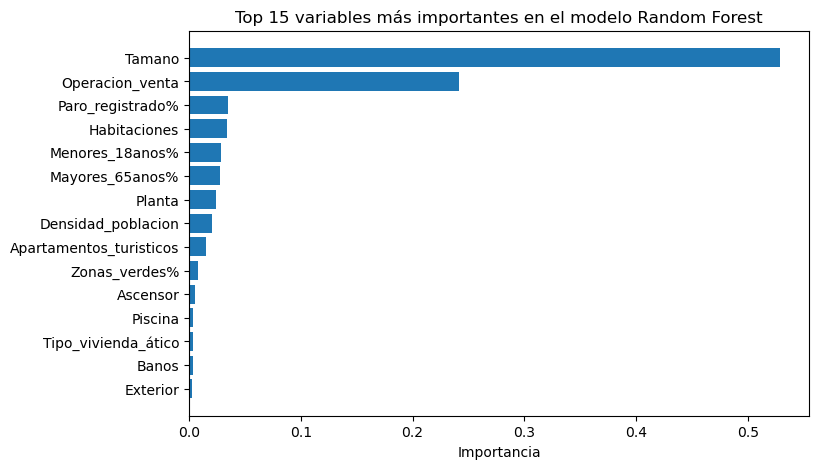

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# Extraer importancias
importancias = rf_final.named_steps['modelo'].feature_importances_
features = X_train.columns

# Crear DataFrame ordenado
imp_df = pd.DataFrame({
    'Variable': features,
    'Importancia': importancias
}).sort_values(by='Importancia', ascending=False).head(15)

# Mostrar tabla y gráfico
display(imp_df)

plt.figure(figsize=(8,5))
plt.barh(imp_df['Variable'], imp_df['Importancia'])
plt.gca().invert_yaxis()
plt.title('Top 15 variables más importantes en el modelo Random Forest')
plt.xlabel('Importancia')
plt.show()
